In [39]:
import xarray as xr
import numpy as np


[xmin, xmax, ymin, ymax] = [334, 350, 10, 30]
[tmin, tmax] = ["1993", "2022"]
season_order = ['DJF', 'MAM', 'JJA', 'SON']

ds_sbc = xr.open_mfdataset('/gxfs_work/geomar/smomw639/runtime/fesom-2.6/core2/core2-budget/analysis/fesom/fesom_core2_fjra_budget_mld1_m_1980_2023_0.25.nc')
ds_sbc['lon'] = (ds_sbc['lon'] + 360) % 360
ds_sbc = ds_sbc.sortby('lon').sel(lon=slice(xmin,xmax), lat=slice(ymin,ymax), time=slice(tmin,tmax))

ds_mld = xr.open_mfdataset('/gxfs_work/geomar/smomw639/runtime/fesom-2.6/core2/core2-budget/analysis/fesom/fesom_core2_fjra_oce2d_m_1980_2023_0.25.nc')
ds_mld['lon'] = (ds_mld['lon'] + 360) % 360
ds_mld = ds_mld.sortby('lon').sel(lon=slice(xmin,xmax), lat=slice(ymin,ymax), time=slice(tmin,tmax))

# nflx FIRST (keeps time)
nflx = ds_sbc['heat_sbc'] * (-ds_mld['MLD1']) * 4.2e6

# seasonal mean AFTER
nflx_season = nflx.groupby('time.season').mean('time').sel(season=season_order)

# numpy if needed
lon = nflx_season['lon'].values
lat = nflx_season['lat'].values
nflx_vals = nflx_season.values



npz = np.load('sstu_1993_2022.npz', allow_pickle=True)
latc = npz["latc"]
latitudes = np.mean(latc, axis=1)  
npz = np.load('fesom_core2_fjra_nflux_mld1_m_1993_2022.npz', allow_pickle=True)
hflxc = npz["nfluxc"]
hflxu = hflxc[:,:,8:]-hflxc[:,:,:8]


/tmp/ipykernel_2550823/886889448.py:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


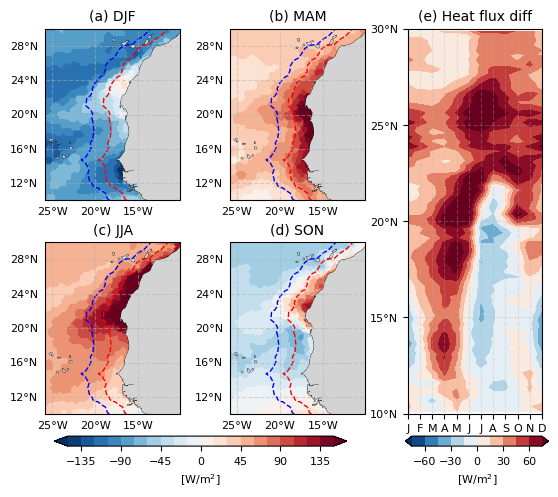

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from cartopy.io.shapereader import Reader, natural_earth
from shapely.geometry import LineString

# Titles
season_titles = ['(a) DJF', '(b) MAM', '(c) JJA', '(d) SON']
hov_label = '(e) Heat flux diff'

# 创建 figure 和 gridspec
fig = plt.figure(figsize=(6.5, 5))
gs = gridspec.GridSpec(2, 3, width_ratios=[1, 1, .9], wspace=0.25, hspace=0.25)
plt.rcParams.update({
    "font.size": 8,
})

# --- 左侧 4 个地图图层 ---
geo_axes = [plt.subplot(gs[0, 0], projection=ccrs.PlateCarree()),
            plt.subplot(gs[0, 1], projection=ccrs.PlateCarree()),
            plt.subplot(gs[1, 0], projection=ccrs.PlateCarree()),
            plt.subplot(gs[1, 1], projection=ccrs.PlateCarree())]

contour_geo = []
for i, ax in enumerate(geo_axes):
    contour = ax.contourf(
        lon, lat, nflx_vals[i],
        levels=np.linspace(-150, 150, 21),
        cmap='RdBu_r',
        extend='both',
        transform=ccrs.PlateCarree()
    )
    contour_geo.append(contour)


    ax.coastlines(linewidth=0.5)
    ax.add_feature(cfeature.LAND, facecolor="lightgray", zorder=2)
    shapefile_path = natural_earth(category='physical', name='coastline', resolution='110m')
    reader = Reader(shapefile_path)
    for record in reader.records():
        geometry = record.geometry
        if isinstance(geometry, LineString) and geometry.length > 10.0:
            coords = [
                (x, y) for x, y in geometry.coords
                if xmin-360 <= x <= xmax-360+1 and ymin <= y <= ymax+1
            ]
            if coords:
                lons, lats = zip(*coords)
                ax.plot([lon - 2 for lon in lons], lats, transform=ccrs.PlateCarree(),
                        color='red', linestyle='--', linewidth=1)
                ax.plot([lon - 4 for lon in lons], lats, transform=ccrs.PlateCarree(),
                        color='blue', linestyle='--', linewidth=1)
    ax.set_extent([np.min(lon)-360, np.max(lon)-360, np.min(lat), np.max(lat)], crs=ccrs.PlateCarree())
    ax.set_title(season_titles[i], fontsize=10)

    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, linestyle="--", alpha=0.5)
    gl.top_labels = gl.right_labels = False
    gl.xlabel_style = gl.ylabel_style = {"fontsize": 8}
    gl.xlocator = mticker.MultipleLocator(5)
    gl.ylocator = mticker.MultipleLocator(4)


# Colorbar for maps
cbar_ax1 = fig.add_axes([0.15, 0.045, 0.45, 0.02])  # [left, bottom, width, height]
cbar1 = fig.colorbar(contour_geo[0], cax=cbar_ax1, orientation='horizontal')
cbar1.set_label('[W/m$^2$]', fontsize=8)

# --- 右侧 Hovmöller 图（hflxd）---
lat_min, lat_max = 10, 30
lat_mask = (latitudes >= lat_min) & (latitudes <= lat_max)
latitudes_subset = latitudes[lat_mask]

# 合并两行用于右侧大图
hov_ax = plt.subplot(gs[:, 2])
hov_data = np.nanmean(hflxu, axis=-1)
hov_data_subset = hov_data[:, lat_mask]

levels = np.linspace(-75, 75, 11)  # 根据你的数据调整
c = hov_ax.contourf(np.arange(12), latitudes_subset, hov_data_subset.T, levels=levels,
                    cmap='RdBu_r', extend='both')

hov_ax.set_title(hov_label, fontsize=10)
hov_ax.set_xticks(np.arange(12))
hov_ax.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'], fontsize=8)
hov_ax.set_ylim(lat_min, lat_max)
hov_ax.set_yticks(np.arange(lat_min, lat_max+1, 5))
hov_ax.set_yticklabels([f'{int(l)}°N' for l in np.arange(lat_min, lat_max+1, 5)], fontsize=8)
hov_ax.grid(True, linestyle='--', alpha=0.3)

# Colorbar for Hovmöller
cbar_ax2 = fig.add_axes([0.69, 0.045, 0.22, 0.02])  # [left, bottom, width, height]
cbar2 = fig.colorbar(c, cax=cbar_ax2, orientation='horizontal')
cbar2.set_label('[W/m$^2$]', fontsize=8)  # 替换成你的单位

plt.tight_layout()
plt.savefig("fig7.png", dpi=300, bbox_inches='tight')
plt.show()
